# Exploring singlepoint

In [14]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import py3Dmol
import requests
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame


# For highlight colors
from matplotlib.colors import ColorConverter
import matplotlib.ticker as mticker

from ipywidgets import interact,fixed,IntSlider


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from support_mvp.backup_plot_diagram.data_handler import read_parts, get_paths, read_properties_sp, renamed_load
from scoring.make_structures import single_atom_remover    

# Custom functions 
from my_utils.visualization import draw_generation,conf_viewer, natural_keys, atoi
from my_utils.classes import Generation, Conformers, Individual

#IPythonConsole.drawOptions.addAtomIndices = True
#IPythonConsole.molSize = 300,300
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.legendFontSize = 38


font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


dft_base = Path('/home/magstr/dft_data')

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114

## Load the reference energies

In [15]:
d = read_parts()

In [16]:
#d

NH3 -> N2 : -11.0351 kcal/mol

NH3 -> N2_NH3 : -13.5287 kcal/mol

NH3+ -> NH3 : 18.2909 kcal/mol

### Analyze the final conformer pickle object. 

In [17]:
conformer_file = Path('../data/final_dft_opt.pkl')

with open(conformer_file, "rb") as f:
    conf = pickle.load(f)

In [12]:
df = conf.conf2pd_dft()
df.head(10)

# Remove the weirs radical ones
df = df[5::]

In [13]:
df

,smiles,idx,cut_idx,score,energy,dft_singlepoint_conf,final_dft_opt,scoring_function
5,N#Cc1cnc(C#N)c(N)c1,"(6, 33)",9,-81.128043,-81.128043,-38.093810,-36.495750,rdkit_embed_scoring_NH3plustoNH3
6,CCNC(N)CCF,"(32, 22)",4,-55.531957,-55.531957,-100.459113,-35.395858,rdkit_embed_scoring_NH3toN2
7,N#Cc1ncc(C(=O)CO)cc1N,"(42, 5)",12,-78.492543,-78.492543,-46.127413,-31.687753,rdkit_embed_scoring_NH3plustoNH3
8,CNC(N)Cc1ccccc1,"(44, 29)",3,-56.935008,-56.935008,-135.072806,-31.197087,rdkit_embed_scoring_NH3toN2
9,CNCCC1(N)CCCCC1,"(29, 44)",5,-74.215383,-74.215383,-24.063455,-31.154052,rdkit_embed_scoring_NH3toN2
...,...,...,...,...,...,...,...,...
135,NCC=Cc1ncnc2ccccc12,"(35, 49)",0,-35.310396,-35.310396,4.680886,-0.282772,rdkit_embed_scoring
136,CC(=O)c1ccc(F)c(C(=O)CN)c1,"(11, 43)",12,-25.923785,-25.923785,10.900545,0.138115,rdkit_embed_scoring
137,CC(=O)c1cc(O)c(N)c(C=O)c1,"(30, 14)",8,-54.967670,-54.967670,-13.341908,1.078720,rdkit_embed_scoring_NH3plustoNH3
138,CNC(=O)Oc1cc(C(=O)C(=O)Br)cc(N)c1F,"(43, 22)",15,-63.445170,-63.445170,-13.138022,3.147142,rdkit_embed_scoring_NH3plustoNH3


In [8]:
AddMoleculeColumnToFrame(df, smilesCol='smiles')

,smiles,idx,cut_idx,score,energy,dft_singlepoint_conf,final_dft_opt,scoring_function,ROMol
5,N#Cc1cnc(C#N)c(N)c1,"(6, 33)",9,-81.128043,-81.128043,-38.093810,-36.495750,rdkit_embed_scoring_NH3plustoNH3,
6,CCNC(N)CCF,"(32, 22)",4,-55.531957,-55.531957,-100.459113,-35.395858,rdkit_embed_scoring_NH3toN2,
7,N#Cc1ncc(C(=O)CO)cc1N,"(42, 5)",12,-78.492543,-78.492543,-46.127413,-31.687753,rdkit_embed_scoring_NH3plustoNH3,
8,CNC(N)Cc1ccccc1,"(44, 29)",3,-56.935008,-56.935008,-135.072806,-31.197087,rdkit_embed_scoring_NH3toN2,
9,CNCCC1(N)CCCCC1,"(29, 44)",5,-74.215383,-74.215383,-24.063455,-31.154052,rdkit_embed_scoring_NH3toN2,
...,...,...,...,...,...,...,...,...,...
135,NCC=Cc1ncnc2ccccc12,"(35, 49)",0,-35.310396,-35.310396,4.680886,-0.282772,rdkit_embed_scoring,
136,CC(=O)c1ccc(F)c(C(=O)CN)c1,"(11, 43)",12,-25.923785,-25.923785,10.900545,0.138115,rdkit_embed_scoring,
137,CC(=O)c1cc(O)c(N)c(C=O)c1,"(30, 14)",8,-54.967670,-54.967670,-13.341908,1.078720,rdkit_embed_scoring_NH3plustoNH3,
138,CNC(=O)Oc1cc(C(=O)C(=O)Br)cc(N)c1F,"(43, 22)",15,-63.445170,-63.445170,-13.138022,3.147142,rdkit_embed_scoring_NH3plustoNH3,

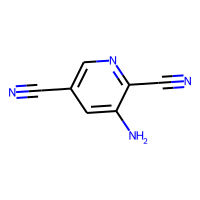
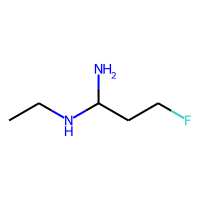
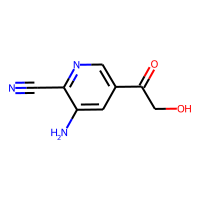
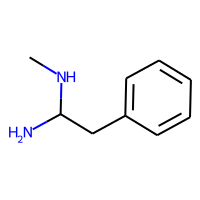
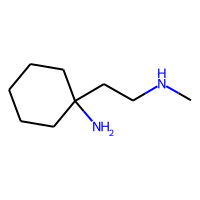
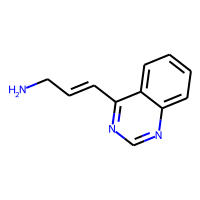
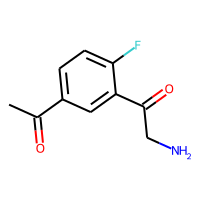
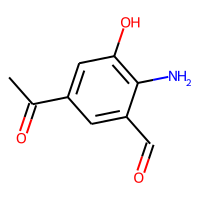
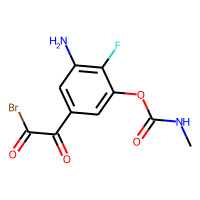
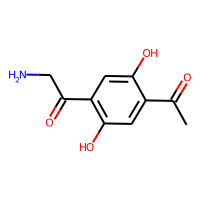

In [9]:
df

In [11]:

# Round the dft valus
df['final_dft_opt'] = df['final_dft_opt'].apply(lambda x: round(x, 2))

# Create the three scoring dataframes
df_n2binding = df[df['scoring_function'] =='rdkit_embed_scoring'].copy()
df_nh3ton2 = df[df['scoring_function'] =='rdkit_embed_scoring_NH3toN2'].copy()
df_reduction_step = df[df['scoring_function'] =='rdkit_embed_scoring_NH3plustoNH3'].copy()
#.copy()

In [12]:
mols = [Chem.MolFromSmiles(x) for x in df['smiles']]
score = [round(score,2) for score in df['final_dft_opt']]
score_xtb = [round(score,2) for score in df['score']]
scoring_functions = [func for func in df['scoring_function']]
idx_gen = [idx_gen for idx_gen in df['idx']]

In [13]:
f_maps = {'rdkit_embed_scoring': 'NH3 -> NH3 - N2',
         'rdkit_embed_scoring_NH3toN2': 'NH3 -> N2', 
         'rdkit_embed_scoring_NH3plustoNH3':'NH3+ -> NH3'}

In [11]:
# https://api.postera.ai/api/v1/docs/#operation/api_v1_superstructure_create
API_KEY = 'v1:oFoDtYIVmQO674syroHgHA'

def get_fastSA(smiles_list):
  response = requests.post(
      'https://api.postera.ai/api/v1/synthetic-accessibility/fast-score/batch/',
      headers={'X-API-KEY': API_KEY},
      json={'smilesList': smiles_list}
  )
  return response.json()#['results']


def get_SA(smiles_list):
  response = requests.post(
      'https://api.postera.ai/api/v1/synthetic-accessibility/retrosynthesis/batch/',
      headers={'X-API-KEY': API_KEY},
      json={
          'smilesList': smiles_list,
          'catalogs': catalogs,
          "maxLeadTimeWeeks": maxLeadTimeWeeks
        }
  )
  return response.json()#['results']

def get_routes(smiles_list):
  response = requests.post(
      'https://api.postera.ai/api/v1/retrosynthesis/batch/',
      headers={'X-API-KEY': API_KEY},
      json={
          'smilesList': smiles_list,
          'catalogs': catalogs,
          "maxLeadTimeWeeks": maxLeadTimeWeeks
        }
  )
  return response.json()#['results']

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [78]:
global catalogs, maxLeadTimeWeeks
catalogs = [
"generic",
# "enamine_bb",
# "enamine_made",
# "enamine_real",
"molport",
"emolecules",
"wuxi_bb_screening",
"wuxi_galaxi",
"mcule",
"mcule_ultimate"
]
maxLeadTimeWeeks = 2

In [81]:
smiles_hydro=[]
for i,row in df_n2binding[['smiles','cut_idx']].iterrows():
    prim_match = Chem.MolFromSmarts("[NX3;H2]")
    # Remove the cut idx amine to prevent it hogging the SA score
    removed_mol = single_atom_remover(Chem.MolFromSmiles(row['smiles']), row['cut_idx'])
    smiles_hydro.append(Chem.MolToSmiles(removed_mol))

In [82]:
df_n2binding

,smiles,idx,cut_idx,score,energy,dft_singlepoint_conf,final_dft_opt,scoring_function
95,CC(=O)Nc1ccc(F)c(C(=O)Cc2ccnc(N)c2)c1,"(15, 16)",18,-49.427804,-49.427804,-9.094086,-17.46,rdkit_embed_scoring
105,NCCCOc1ncnc2cccnc12,"(41, 15)",0,-45.797946,-45.797946,-30.470303,-15.84,rdkit_embed_scoring
106,NC=NC(=O)c1cccc(Br)c1,"(42, 17)",0,-54.707044,-54.707044,-15.434539,-15.61,rdkit_embed_scoring
115,C=C(CCCN)c1n[nH]c2ccccc12,"(13, 32)",5,-88.400354,-88.400354,-44.772186,-13.72,rdkit_embed_scoring
119,NCCCOc1ccnc2cccnc12,"(45, 17)",0,-44.979458,-44.979458,-0.106733,-12.12,rdkit_embed_scoring
126,NCCOC(=O)c1ncnc2ccccc12,"(50, 11)",0,-38.419746,-38.419746,0.688340,-8.33,rdkit_embed_scoring
128,NCCCc1ncnc2ccccc12,"(24, 37)",0,-42.747249,-42.747249,-7.009156,-7.58,rdkit_embed_scoring
129,CCc1cccc(C(=O)N=CN)c1,"(47, 15)",11,-62.786973,-62.786973,-8.841232,-7.52,rdkit_embed_scoring
132,CC(=O)c1ccc(F)c(C(=O)N=CN)c1,"(25, 42)",13,-53.416507,-53.416507,-0.852550,-5.53,rdkit_embed_scoring
134,NCCc1ncnc2ccccc12,"(16, 36)",0,-33.182780,-33.182780,1.585331,-0.33,rdkit_embed_scoring


In [83]:
# routes = []
# chunk_size = 10 #API allows for max 10

# for lst in list(chunks(smiles_list, chunk_size)):
#   routes.append(get_routes(lst)).get('error',False) else empty_dict for r in results_hydro[n]['results']] for n in range(len(results_hydro))]
#flat_list = [item for subli

In [85]:
results_hydro = []
chunk_size = 10 #API allows for max 10

for lst in list(chunks(smiles_hydro, chunk_size)):
  results_hydro.append(get_SA(lst))

In [86]:
with open('results_hydro_n2binding', 'w') as fout:
    json.dump(results_hydro, fout)

In [87]:
#with open('results_hydro_', 'r') as f:
#     results_hydro= json.load(f)

In [88]:
results_hydro

[{'results': [{'SAData': {'score': 0.165679,
     'minNumSteps': 2,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=CC%28%3DO%29Nc1ccc%28F%29c%28C%28%3DO%29Cc2ccncc2%29c1'}},
   {'SAData': {'score': 0.08237003,
     'minNumSteps': 1,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=CCCOc1ncnc2cccnc12'}},
   {'SAData': {'score': 0.08567823,
     'minNumSteps': 1,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=C%3DNC%28%3DO%29c1cccc%28Br%29c1'}},
   {'SAData': {'score': 0.24631006,
     'minNumSteps': 3,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=C%3DC%28CCC%29c1n%5BnH%5Dc2ccccc12'}},
   {'SAData': {'score': 0.081257135,
     'minNumSteps': 1,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=CCCOc1ccnc2cccnc12'}},
   {'SAData': {'score': 0.09264079,
     'minNumSteps': 1,
     'manifoldLink': 'https://app.postera.ai/manifold?smiles=CCOC%28%3DO%29c1ncnc2ccccc12'}},
   {'SAData': {'score': 0.081063,
     'minNumSteps': 1,

In [89]:
empty_dict ={'score':None, 'minNumSteps':None}

In [90]:
res = [[r['SAData'] if not r.get('error',False) else empty_dict for r in results_hydro[n]['results']] for n in range(len(results_hydro))]
flat_list = [item for sublist in res for item in sublist]

score = [x['score'] for x in flat_list]

steps = [x['minNumSteps'] for x in flat_list]

# Put the final results into the dataframe
df_n2binding['postera_score'] = score
df_n2binding['steps'] = steps

df_n2binding.loc[:, 'scoring_function'] = df_n2binding['scoring_function'].apply(lambda x: f_maps[x])

In [91]:
df_n2binding

,smiles,idx,cut_idx,score,energy,dft_singlepoint_conf,final_dft_opt,scoring_function,postera_score,steps
95,CC(=O)Nc1ccc(F)c(C(=O)Cc2ccnc(N)c2)c1,"(15, 16)",18,-49.427804,-49.427804,-9.094086,-17.46,NH3 -> NH3 - N2,0.165679,2
105,NCCCOc1ncnc2cccnc12,"(41, 15)",0,-45.797946,-45.797946,-30.470303,-15.84,NH3 -> NH3 - N2,0.082370,1
106,NC=NC(=O)c1cccc(Br)c1,"(42, 17)",0,-54.707044,-54.707044,-15.434539,-15.61,NH3 -> NH3 - N2,0.085678,1
115,C=C(CCCN)c1n[nH]c2ccccc12,"(13, 32)",5,-88.400354,-88.400354,-44.772186,-13.72,NH3 -> NH3 - N2,0.246310,3
119,NCCCOc1ccnc2cccnc12,"(45, 17)",0,-44.979458,-44.979458,-0.106733,-12.12,NH3 -> NH3 - N2,0.081257,1
126,NCCOC(=O)c1ncnc2ccccc12,"(50, 11)",0,-38.419746,-38.419746,0.688340,-8.33,NH3 -> NH3 - N2,0.092641,1
128,NCCCc1ncnc2ccccc12,"(24, 37)",0,-42.747249,-42.747249,-7.009156,-7.58,NH3 -> NH3 - N2,0.081063,1
129,CCc1cccc(C(=O)N=CN)c1,"(47, 15)",11,-62.786973,-62.786973,-8.841232,-7.52,NH3 -> NH3 - N2,0.085624,1
132,CC(=O)c1ccc(F)c(C(=O)N=CN)c1,"(25, 42)",13,-53.416507,-53.416507,-0.852550,-5.53,NH3 -> NH3 - N2,0.087214,1
134,NCCc1ncnc2ccccc12,"(16, 36)",0,-33.182780,-33.182780,1.585331,-0.33,NH3 -> NH3 - N2,0.081222,1


In [92]:
final_df = df_n2binding[['smiles', 'final_dft_opt','scoring_function', 'postera_score', 'steps']].copy()

In [93]:
final_df

,smiles,final_dft_opt,scoring_function,postera_score,steps
95,CC(=O)Nc1ccc(F)c(C(=O)Cc2ccnc(N)c2)c1,-17.46,NH3 -> NH3 - N2,0.165679,2
105,NCCCOc1ncnc2cccnc12,-15.84,NH3 -> NH3 - N2,0.082370,1
106,NC=NC(=O)c1cccc(Br)c1,-15.61,NH3 -> NH3 - N2,0.085678,1
115,C=C(CCCN)c1n[nH]c2ccccc12,-13.72,NH3 -> NH3 - N2,0.246310,3
119,NCCCOc1ccnc2cccnc12,-12.12,NH3 -> NH3 - N2,0.081257,1
126,NCCOC(=O)c1ncnc2ccccc12,-8.33,NH3 -> NH3 - N2,0.092641,1
128,NCCCc1ncnc2ccccc12,-7.58,NH3 -> NH3 - N2,0.081063,1
129,CCc1cccc(C(=O)N=CN)c1,-7.52,NH3 -> NH3 - N2,0.085624,1
132,CC(=O)c1ccc(F)c(C(=O)N=CN)c1,-5.53,NH3 -> NH3 - N2,0.087214,1
134,NCCc1ncnc2ccccc12,-0.33,NH3 -> NH3 - N2,0.081222,1


In [87]:
#AddMoleculeColumnToFrame(final_df, smilesCol='smiles')

In [95]:
final_df

,smiles,final_dft_opt,scoring_function,postera_score,steps
95,CC(=O)Nc1ccc(F)c(C(=O)Cc2ccnc(N)c2)c1,-17.46,NH3 -> NH3 - N2,0.165679,2
105,NCCCOc1ncnc2cccnc12,-15.84,NH3 -> NH3 - N2,0.082370,1
106,NC=NC(=O)c1cccc(Br)c1,-15.61,NH3 -> NH3 - N2,0.085678,1
115,C=C(CCCN)c1n[nH]c2ccccc12,-13.72,NH3 -> NH3 - N2,0.246310,3
119,NCCCOc1ccnc2cccnc12,-12.12,NH3 -> NH3 - N2,0.081257,1
126,NCCOC(=O)c1ncnc2ccccc12,-8.33,NH3 -> NH3 - N2,0.092641,1
128,NCCCc1ncnc2ccccc12,-7.58,NH3 -> NH3 - N2,0.081063,1
129,CCc1cccc(C(=O)N=CN)c1,-7.52,NH3 -> NH3 - N2,0.085624,1
132,CC(=O)c1ccc(F)c(C(=O)N=CN)c1,-5.53,NH3 -> NH3 - N2,0.087214,1
134,NCCc1ncnc2ccccc12,-0.33,NH3 -> NH3 - N2,0.081222,1


In [94]:
final_df.to_pickle('df_n2binding.pkl', compression=None)

# Visualization

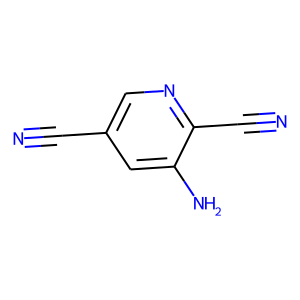

In [14]:
Draw.MolToImage(mols[0],returnSVG=True)

In [28]:
img  = Draw.MolsToGridImage(mols,molsPerRow=4,maxMols=140,legends=[f'{f_maps[scoring_function]}  |  DFT:  {score} |  xTB: {score_xtb}' for scoring_function, score,score_xtb, idx in zip(scoring_functions,score,score_xtb, idx_gen)],subImgSize=(400,200), returnPNG=False)
img.save('final_opt_filtering.png', format='png')  

In [17]:
with open('final_opt_filtering.svg','w') as f:
    f.write(img.data)

## Visualizing the structures

In [62]:
opt_dir = Path('/home/magstr/dft_data/0_140_dft_opts')

In [77]:
opt_traj = opt_dir/f'0/12_8/Mo_NH3/orca_trj.xyz'
opt_final = opt_dir/f'0/12_8/Mo_NH3/orca.xyz'

In [93]:
# Randomly get all opt structures
opt_structures = sorted(opt_dir.rglob('*orca.xyz'))

In [104]:
def view_opt(idx, opt_structures):
    struct = str(opt_structures[idx])
    return draw_generation(struct, trajectory=False)

In [107]:
def view_opt2(opt_structure):
    return draw_generation(str(opt_structure), trajectory=False)

In [111]:
#interact(view_opt2, opt_structure=opt_structures, width=fixed(800), height=fixed(500));

In [105]:
# 20 is a regular carbon one. 
# 195 interesting

interact(view_opt,idx=IntSlider(min=0,max=len(opt_structures)-1,step=1), opt_structures=fixed(opt_structures), width=fixed(800), height=fixed(500));

interactive(children=(IntSlider(value=0, description='idx', max=281), Output()), _dom_classes=('widget-interac…

In [114]:
#draw_generation(str(opt_final), trajectory=False)
draw_generation(str(opt_traj), trajectory=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Make nice plots with all 44 candidates

In [20]:
# idx for top ten mols
idxs = [
    6,
    8,
    9,
    11,
    13,
    14,
    15,
    16,
    18,
    19,
    20,
    21,
    23,
    25,
    26,
    95,
    105,
    106,
    115,
    119,
    126,
    128,
    129,
    132,
    134,
    135,
    136,
    139,
    5,
    7,
    10,
    12,
    17,
    22,
    24,
    29,
    35,
    40,
    47,
    65,
    70,
    83,
    90,
]
mol_list = [ind for i, ind in enumerate(conf.molecules) if i in idxs]

In [21]:
mol_list

[Individual(smiles='N#Cc1cnc(C#N)c(N)c1'),
 Individual(smiles='CCNC(N)CCF'),
 Individual(smiles='N#Cc1ncc(C(=O)CO)cc1N'),
 Individual(smiles='CNC(N)Cc1ccccc1'),
 Individual(smiles='CNCCC1(N)CCCCC1'),
 Individual(smiles='N#Cc1ncc(CC(=O)O)cc1N'),
 Individual(smiles='CCC(N)CNc1cccc(S)c1'),
 Individual(smiles='NC(CC(=S)C=O)c1cccc(F)c1'),
 Individual(smiles='CCCOC(=O)NCC1(N)CCCCC1'),
 Individual(smiles='CCCCN1CCCC(N)(C2CCCC2)C1'),
 Individual(smiles='CC(N)Cc1ccc(Sc2ccccc2)cc1'),
 Individual(smiles='CC(C)(N)CCC1CCCCC1'),
 Individual(smiles='Nc1ccc(F)c(C(=O)C(=O)C(=O)Cl)c1'),
 Individual(smiles='NC1(CCCCCl)CCCCC1'),
 Individual(smiles='CCCN1CCCC(N)(C2CCCC2)C1'),
 Individual(smiles='CCC(C)(C)CC(C)(C)N'),
 Individual(smiles='CC(N)Cc1ccc(Cc2ccccc2)cc1'),
 Individual(smiles='Nc1ccccc1N=CC(=O)Cl'),
 Individual(smiles='C=C(C)CC(C)(C)N'),
 Individual(smiles='Nc1cc(C=O)c(C=O)cc1C=O'),
 Individual(smiles='CC(N)Cc1ccc(CCl)cc1'),
 Individual(smiles='CC(N)CCc1ccc(-c2ccccc2)cc1'),
 Individual(smiles='Nc1c

In [23]:
conf.molecules= mol_list

In [25]:
len(mol_list)

43

In [26]:
df = conf.conf2pd_dft()

In [29]:
df.head()

,smiles,idx,cut_idx,score,energy,dft_singlepoint_conf,final_dft_opt,scoring_function
0,N#Cc1cnc(C#N)c(N)c1,"(6, 33)",9,-81.128043,-81.128043,-38.093810,-36.495750,rdkit_embed_scoring_NH3plustoNH3
1,CCNC(N)CCF,"(32, 22)",4,-55.531957,-55.531957,-100.459113,-35.395858,rdkit_embed_scoring_NH3toN2
2,N#Cc1ncc(C(=O)CO)cc1N,"(42, 5)",12,-78.492543,-78.492543,-46.127413,-31.687753,rdkit_embed_scoring_NH3plustoNH3
3,CNC(N)Cc1ccccc1,"(44, 29)",3,-56.935008,-56.935008,-135.072806,-31.197087,rdkit_embed_scoring_NH3toN2
4,CNCCC1(N)CCCCC1,"(29, 44)",5,-74.215383,-74.215383,-24.063455,-31.154052,rdkit_embed_scoring_NH3toN2


In [31]:
f_maps = {'rdkit_embed_scoring': 'NH3 -> NH3 - N2',
         'rdkit_embed_scoring_NH3toN2': 'NH3 -> N2', 
         'rdkit_embed_scoring_NH3plustoNH3':'NH3+ -> NH3'}

In [42]:
mols = [Chem.MolFromSmiles(x) for x in df['smiles']]
score = [round(score,2) for score in df['final_dft_opt']]
score_xtb = [round(score,2) for score in df['energy']]
scoring_functions = [func for func in df['scoring_function']]

In [43]:
removed = []
for elem in mols:    
    # Replace tricky primary amines in the frag:
    prim_match = Chem.MolFromSmarts("[NX3;H2]")
    rm = Chem.ReplaceSubstructs(
                                elem,
                                prim_match,
                                Chem.MolFromSmiles("[1*]"),
                                replaceAll=True,
                            )[0]
    removed.append(rm)

In [85]:
IPythonConsole.drawOptions.legendFontSize = 38

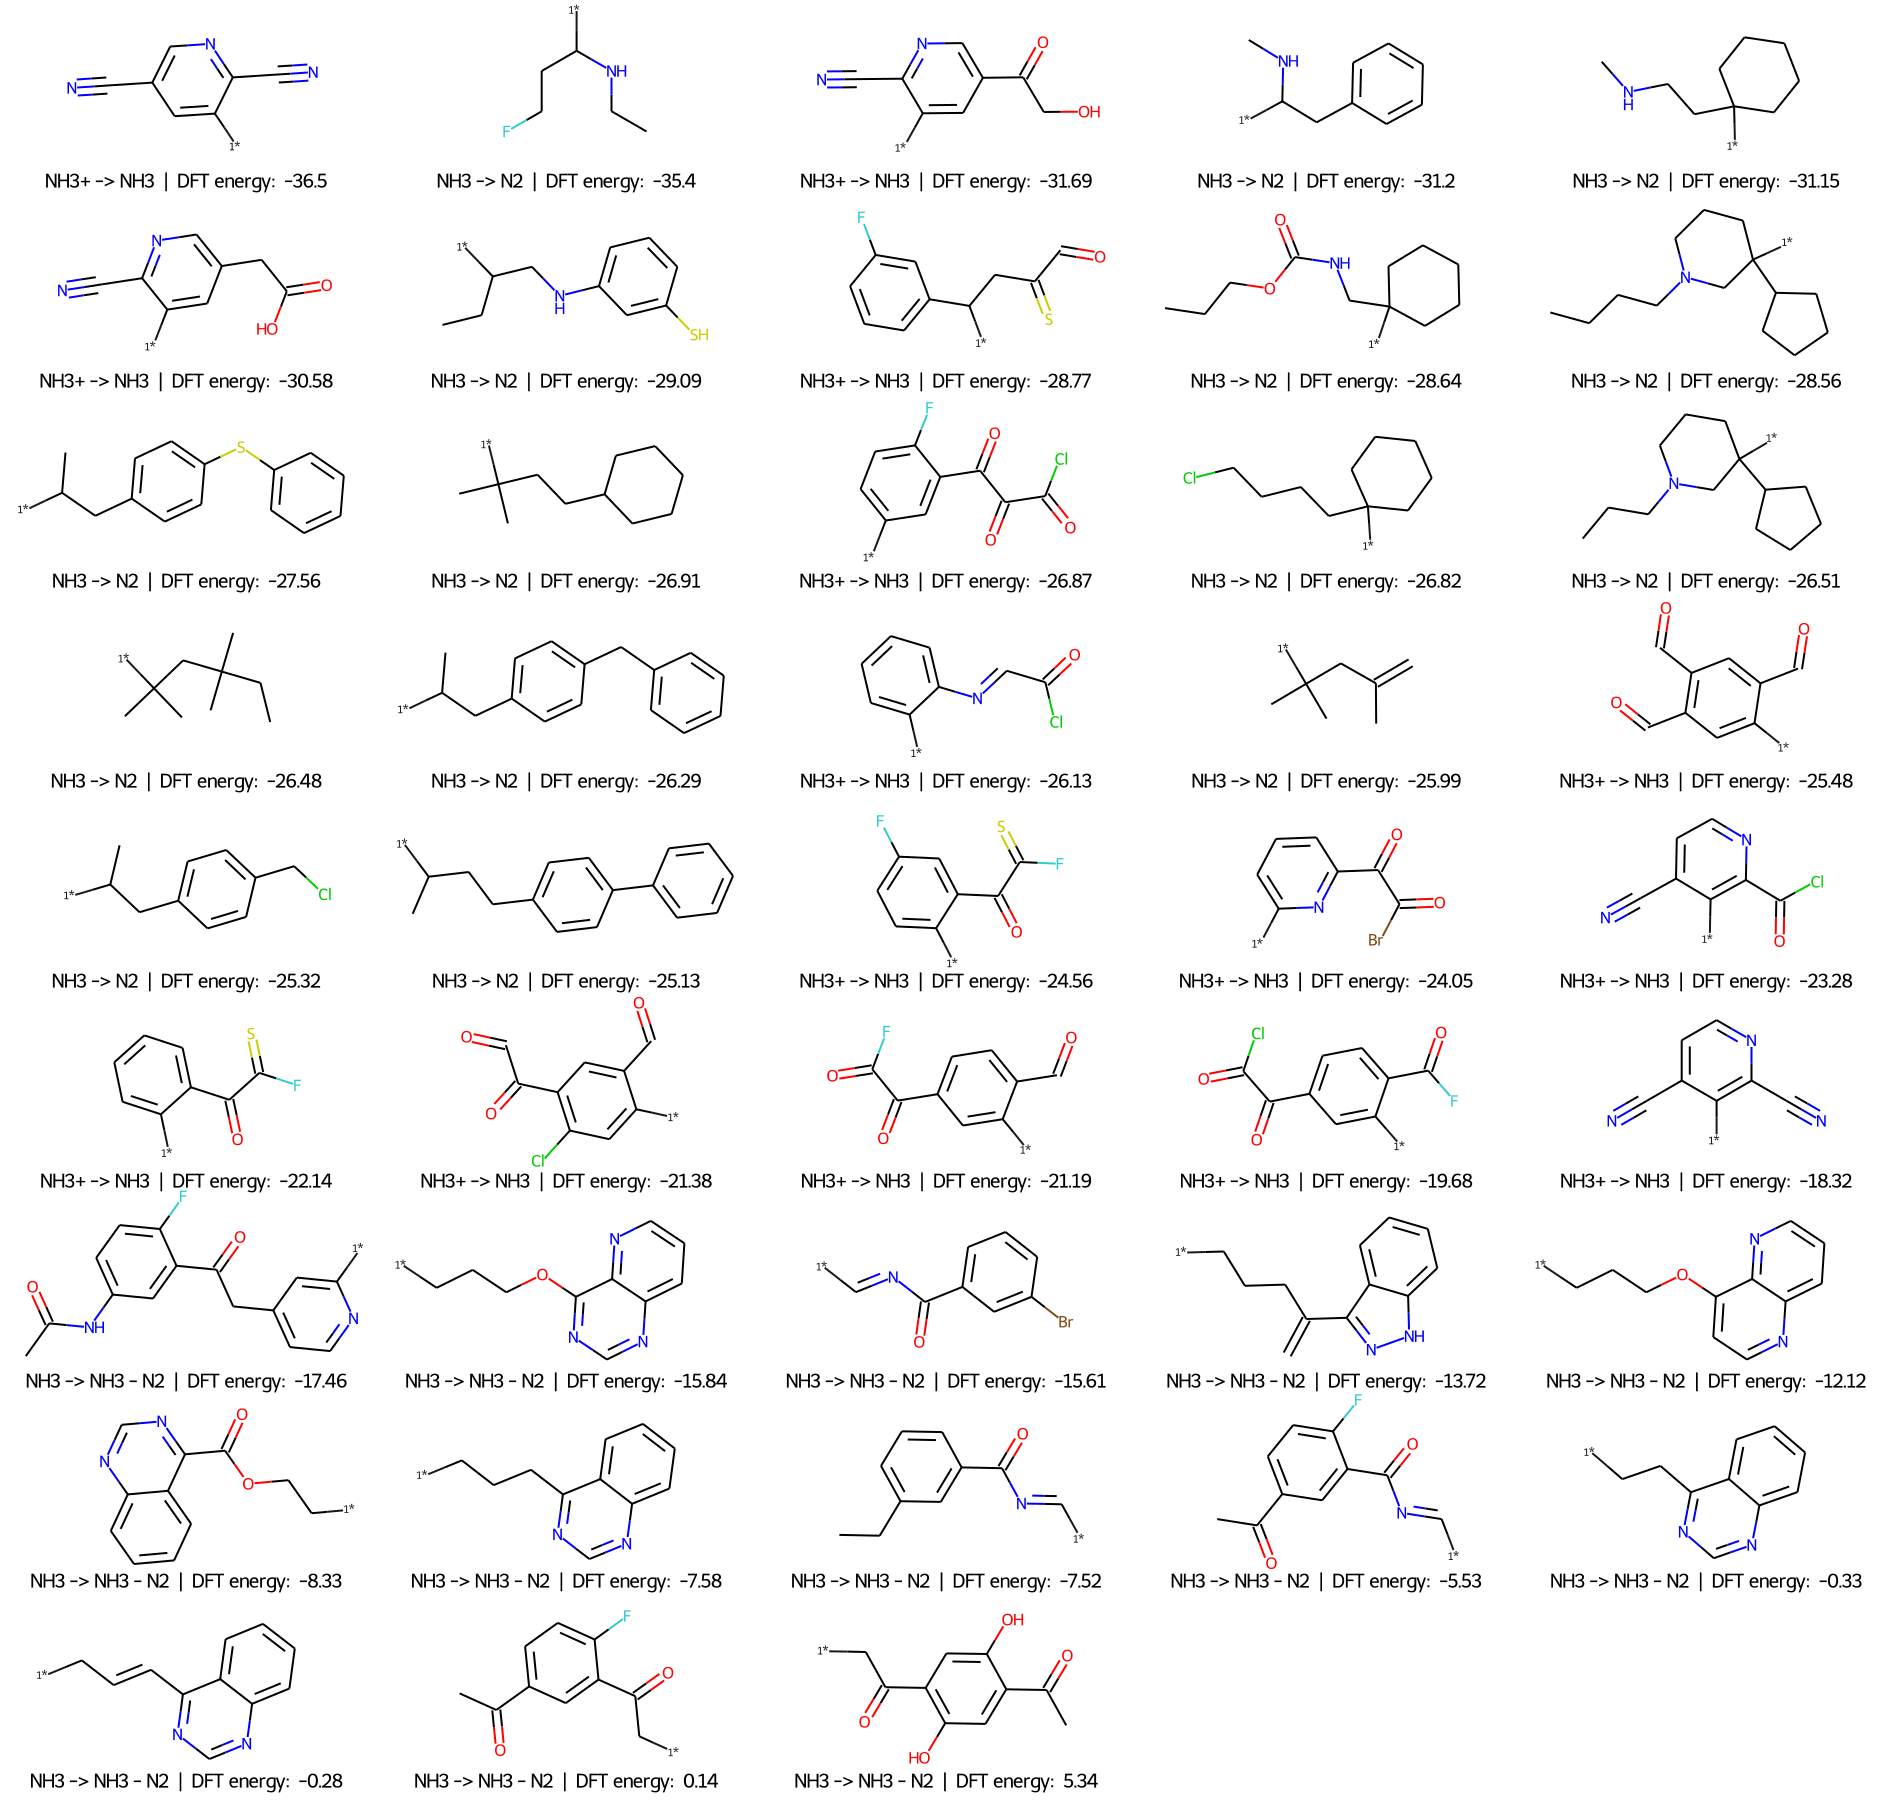

In [86]:
img  = Draw.MolsToGridImage(removed,molsPerRow=5,maxMols=300,legends=[f'{f_maps[scoring_function]}  |  DFT energy:  {score}' for scoring_function, score,score_xtb in zip(scoring_functions,score,score_xtb)],subImgSize=(380,200), returnPNG=False,useSVG=True)

#img.save('/home/magstr/Documents/Paper/figures/43_final_mols.png', format='png')
#img
with open('/home/magstr/Documents/Paper/figures/43_final_mols.svg','w') as f:
    f.write(img.data)
img